# Q1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string 
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

import sklearn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to /Users/sylvia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sylvia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sylvia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sylvia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# a) Download the data.
1)     
In the train data, number of row is 7613 and number of column is 5, so total data points is 38065.     
In the test data, number of row is 3263 and number of column is 4, so total data points is 13052.    
2)    
There are 42.97 % of the training tweets are of real disasters, and 57.03 % of training tweets are not

In [2]:
df_train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})
print('In the train data, number of row is {} and number of column is {}, so total data points is {}. '.format(df_train.shape[0],df_train.shape[1],df_train.shape[0]))
print('In the test data, number of row is {} and number of column is {}, so total data points is {}. '.format(df_test.shape[0],df_test.shape[1],df_test.shape[0]))

In the train data, number of row is 7613 and number of column is 5, so total data points is 7613. 
In the test data, number of row is 3263 and number of column is 4, so total data points is 3263. 


In [3]:
print(df_train.loc[:,'target'].value_counts())
real_pct = float(3271/df_train.shape[0])
notreal_pct = float(4342/df_train.shape[0])
print('There are {} % of the training tweets are of real disasters, and {} % of training tweets are not '.format(round(real_pct*100,2),round(notreal_pct*100,2)))

0    4342
1    3271
Name: target, dtype: int64
There are 42.97 % of the training tweets are of real disasters, and 57.03 % of training tweets are not 


# b) Split the training data.

In [4]:
train, dev = train_test_split(df_train, test_size=0.3, random_state=42)
print(train.shape)
print(dev.shape)

(5329, 5)
(2284, 5)


# c)   Preprocess the Data.
• Convert all the words to lowercase.  
we want to do it, since it will facilitate the future search of words

In [5]:
train = train.applymap(lambda s:s.lower() if type(s) == str else s)
dev = dev.applymap(lambda s:s.lower() if type(s) == str else s)

• Lemmatize all the words (i.e.,convert every word to its root so that all of “running,”“run,” and “runs” are converted to “run” and and all of “good,” “well,” “better,” and “best” are converted to “good”; this is easily done using nltk.stem).      
we want to do it, since we need the meaning of words regardless of the gramma or status will not affect the meanning of words, so this process facilitate the future process of words by eliminate the same meanning of words. 


In [6]:
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()


def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

train['Lemmatize'] = train['text'].apply(lambda x: lemmatize_sentence(x))
dev['Lemmatize'] = dev['text'].apply(lambda x: lemmatize_sentence(x))

• Strip punctuation.  
we want to do it, since punctuation will not affect the analysis of key words and eliminate it will facilitate future analyze. 

In [7]:
def no_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
train["no_punctuations"] = train['Lemmatize'].apply(no_punctuations)
dev["no_punctuations"] = dev['Lemmatize'].apply(no_punctuations)

• Strip the stop words,e.g.,“the”,“and”,“or”.   
we want to do it, since we don't need stop words to define the meaning of sentence, so this process will facilitate the future process of analysis and save time for computing. 

In [8]:
stop = stopwords.words('english')
train['preprocessed_text'] = train['no_punctuations'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
dev['preprocessed_text'] = dev['no_punctuations'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# train['preprocessed_text'] = train['preprocessed_text'].apply(lambda x: x.split())
# dev['preprocessed_text'] = train['preprocessed_text'].apply(lambda x: x.split())
train.head()

,id,keyword,location,text,target,Lemmatize,no_punctuations,preprocessed_text
1186,1707,bridge%20collapse,NaN,ashes 2015: australiaûªs collapse at trent br...,0,ash 2015 : australiaûªs collapse at trent bri...,ash 2015 australiaûªs collapse at trent brid...,ash 2015 australiaûªs collapse trent bridge a...
4071,5789,hail,"carol stream, illinois",great michigan technique camp\nb1g thanks to @...,1,great michigan technique camp b1g thanks to @ ...,great michigan technique camp b1g thanks to b...,great michigan technique camp b1g thanks bmurp...
5461,7789,police,houston,cnn: tennessee movie theater shooting suspect ...,1,cnn : tennessee movie theater shoot suspect ki...,cnn tennessee movie theater shoot suspect kil...,cnn tennessee movie theater shoot suspect kill...
5787,8257,rioting,NaN,still rioting in a couple of hours left until ...,1,still riot in a couple of hour leave until i h...,still riot in a couple of hour leave until i h...,still riot couple hour leave class
7445,10656,wounds,lake highlands,crack in the path where i wiped out this morni...,0,crack in the path where i wipe out this mornin...,crack in the path where i wipe out this mornin...,crack path wipe morning beach run surface woun...


In [9]:
dev.head()

,id,keyword,location,text,target,Lemmatize,no_punctuations,preprocessed_text
2644,3796,destruction,NaN,so you have a new weapon that can cause un-ima...,1,so you have a new weapon that can cause un-ima...,so you have a new weapon that can cause unimag...,new weapon cause unimaginable destruction
2227,3185,deluge,NaN,the f$&amp;@ing things i do for #gishwhes just...,0,the f $ & amp ; @ ing thing i do for # gishwhe...,the f amp ing thing i do for gishwhes jus...,f amp ing thing gishwhes get soak deluge go pa...
5448,7769,police,uk,dt @georgegalloway: rt @galloway4mayor: ûïthe...,1,dt @ georgegalloway : rt @ galloway4mayor : û...,dt georgegalloway rt galloway4mayor ûïthe...,dt georgegalloway rt galloway4mayor ûïthe col...
132,191,aftershock,NaN,aftershock back to school kick off was great. ...,0,aftershock back to school kick off be great . ...,aftershock back to school kick off be great i...,aftershock back school kick great want thank e...
6845,9810,trauma,"montgomery county, md",in response to trauma children of addicts deve...,0,in response to trauma child of addict develop ...,in response to trauma child of addict develop ...,response trauma child addict develop defensive...


# d) Bag of word.    
I set min_df = 5 which means we only include in the vocabulary words that appear in at least 5 different tweets, since 5 might be a good balance, not too large or too small, so it save computing time by avoiding too infrequent words, and still leave fair chance for learning the reast of key words. Total number of features in these vector is 1834.

In [10]:
#bag of word
# frames = [train,dev]
# result = pd.concat(frames)
count_vectorizer = CountVectorizer(binary=True,min_df=5)
# result_vectors = count_vectorizer.fit_transform(result['preprocessed_text']).toarray()
# print(result_vectors.shape)
train_vectors = count_vectorizer.fit_transform(train['preprocessed_text']).toarray()
dev_vectors = count_vectorizer.transform(dev['preprocessed_text']).toarray()
print(train_vectors.shape)
print(dev_vectors.shape)
print( 'total number of features in these vector is {}'.format(dev_vectors.shape[1]))
x_train = train_vectors
y_train = train['target']
x_dev = dev_vectors
y_dev = dev['target']



(5329, 1834)
(2284, 1834)
total number of features in these vector is 1834


# e) Implement a naive Bayes classifier.
F score = 0.7480314960629921 

In [11]:
def Naive_Bayes(x_train, y_train, x_dev):
    
    #creating a matrix to calculate P(0) and P(1)
    likelihood = np.zeros((2, x_train.shape[1]))
    
    #finding the P (xj|Ck)
    for i in range(len([0,1])):
        equal = np.equal(y_train, i)
        likelihood[i, :] = np.sum(x_train[equal], axis = 0) / x_train[equal].shape[0] 
        
    predict = np.zeros(x_dev.shape[0])    
    for i in range (x_dev.shape[0]): 
        prob_list = np.zeros(2)  
        for z in range(2):
            items = x_train.shape[0]
            before = np.bincount(y_train)/items
            after = before[z]
            new_likelihood = likelihood[z, :]
            for h in range(x_dev[i,:].shape[0]):
                if x_dev[i,h] == True:
                    p = new_likelihood[h]
                else:
                    p = 1 - new_likelihood[h]
                after = after * p
            prob_list[z] = after
        #finding the argmax of the conditional prob
        result_type = [0,1]
        result = result_type[np.argmax(prob_list)]
        predict[i] = result
    return predict
Naive_Bayes(x_train, y_train, x_dev)

array([0., 0., 1., ..., 1., 1., 1.])

In [12]:
NB_pridict = Naive_Bayes(x_train, y_train, x_dev)
F_score = f1_score(y_dev,NB_pridict)
print(F_score)

0.7480314960629921


# f) Logistic regression prediction.   
F score = 0.7377584330794341, and the most important words for deciding whether a tweet is about a real disaster or not is: hiroshima

In [13]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
log_predict_binary = logreg.predict(x_dev)
F_score = f1_score(y_dev,log_predict_binary)
print(F_score)
importance = logreg.coef_
index_word = np.argmax(importance)
important_word = count_vectorizer.get_feature_names()
print('The most imprtant word is ' + important_word[index_word])

0.7377584330794341
The most imprtant word is hiroshima


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# g) Linear SVM prediction   
What hyperparameter value results in the best classification perormance:   C= 0.01   
This best F1 score of linear SVM classifier(0.7377584330794341) is very similar and just slightly smaller than F1_score of logistic regression classifier(0.7369040612124779) from the previous section   
The most important words for deciding whether a tweet is about a real disaster or not is: hiroshima     
this is same as the most important words for logistic regression.

In [14]:
C = [0.01, 0.1, 1.0, 10.0, 100.0]
F_score_list = []
for i in C:
    linear_svm = LinearSVC(C = i)
    linear_svm.fit(x_train,y_train)
    linear_predict_binary = linear_svm.predict(x_dev)
    F_score = f1_score(y_dev,linear_predict_binary)
    F_score_list.append(F_score)
F_score_list


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.7369040612124779,
 0.7360350492880614,
 0.7174934725848563,
 0.6979113601630158,
 0.671763506625892]

The best C = 0.01, with the best F1 score = 0.7369040612124779.


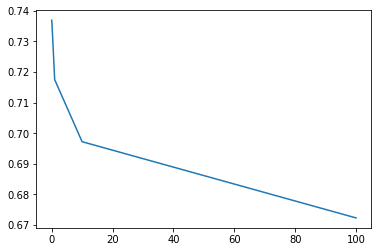

In [14]:
plt.plot(C, F_score_list)
index_c = np.argmax(F_score_list)
print('The best C = {}, with the best F1 score = {}.' .format(C[index_c], max(F_score_list)))

In [15]:
linear_svm = LinearSVC(C = 0.01)
linear_svm.fit(x_train,y_train)
importance_svm = linear_svm.coef_
index_svm = np.argmax(importance_svm)
important_word = count_vectorizer.get_feature_names()
print('The most imprtant word is ' + important_word[index_svm])

The most imprtant word is hiroshima


# h) Non-linear SVM prediction.   
The best C = 100.0, with the best F1 score = 0.7470153496304719

In [16]:
C = [0.01, 0.1, 1.0, 10.0, 100.0]
Fnonlear_list = []
for i in C:
    nonlinear_svm = SVC(kernel='rbf', C = i, probability = True, gamma='auto')
    nonlinear_svm.fit(x_train,y_train)
    nonlinear_predict_binary = nonlinear_svm.predict(x_dev)
    Fnonlear_score = f1_score(y_dev,nonlinear_predict_binary)
    Fnonlear_list.append(Fnonlear_score)
    
Fnonlear_list


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.0, 0.0, 0.0, 0.6834804539722572, 0.7470153496304719]

The best C = 100.0, with the best F1 score = 0.7470153496304719.


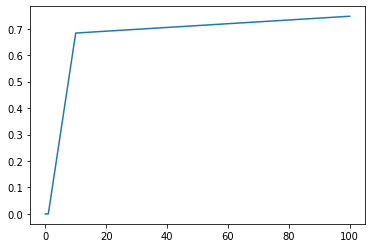

In [17]:
plt.plot(C, Fnonlear_list)
index_c = np.argmax(Fnonlear_list)
print('The best C = {}, with the best F1 score = {}.' .format(C[index_c], max(Fnonlear_list)))

# i) N-gram model.  
We choose M = 5 to avoid the run-time and memory issues, we reduce the threshold from 5 to 6 since 2 gram may increase too much vectors and need higher threshold.  

For e) N-grammodel implement a naive Bayes classifier: F1 score = 0.7199526346950859


For f) N-grammodel Logistic regression prediction, F score = 0.7401746724890829 and important word is The most imprtant word is hiroshima;


For g) N-grammodel Linear SVM prediction, The best C = 0.1, with the best F1 score = 0.7398463227222831, which is slightly more than Logistic regression's F score, the important word is laden which is different to the most important words for Logistic regression;


For h) Non-linear SVM prediction: The best C = 100.0, with the best F1 score = 0.7419354838709676..


Regarding all F score, the best performance classifier is Non-linear SVM prediction, and the result is not that different from bag of word model (and even slightly less accurate than bag of word model in general), but the running time is significantly more than bag of word model, thus we prefer using the bag of word mode. 

In [31]:
N_grammodel = CountVectorizer(binary=True, ngram_range=(1, 2), min_df = 6)
# N_grammodel_vectors = N_grammodel.fit_transform(result['preprocessed_text']).toarray()
# print(N_grammodel_vectors.shape)
n_train_vectors = N_grammodel.fit_transform(train['preprocessed_text']).toarray()
n_dev_vectors = N_grammodel.transform(dev['preprocessed_text']).toarray()
print(n_train_vectors.shape)
print(n_dev_vectors.shape)
print( 'total number of features in these vector is {}'.format(n_dev_vectors.shape[1]))
x_Ntrain = n_train_vectors
y_Ntrain = train['target']
x_Ndev = n_dev_vectors
y_Ndev = dev['target']

(5329, 2138)
(2284, 2138)
total number of features in these vector is 2138


In [32]:
two_grammodel = CountVectorizer(binary=True, ngram_range=(2, 2), min_df=6)
#ransom sample
two_grammodel_vectors = two_grammodel.fit_transform(train['preprocessed_text']).toarray()
two_gram_name = two_grammodel.get_feature_names()
#radom print out 10 2 gram vocabulary
np.random.choice(two_gram_name,size = 10)

array(['gt http', 'flood http', 'crematorium provoke', 'school bus',
       'fear kill', 'past anniversary', 'breaking news',
       'legionnaire disea', 'wave black', 'bomb japan'], dtype='<U26')

In [36]:
# N-grammodel Implement a naive Bayes classifier.
nb_pridict = Naive_Bayes(x_Ntrain, y_Ntrain, x_Ndev)
F_score = f1_score(y_dev,nb_pridict)
print('F1 score = ' + str(F_score))

F1 score = 0.7199526346950859


In [34]:
# N-grammodel Logistic regression prediction
nlogreg = LogisticRegression()
nlogreg.fit(x_Ntrain,y_Ntrain)
nlog_predict_binary = nlogreg.predict(x_Ndev)
nF_score = f1_score(y_Ndev,nlog_predict_binary)
print(nF_score)
nimportance = nlogreg.coef_
nindex_word = np.argmax(nimportance)
important_word = N_grammodel.get_feature_names()
print('The most imprtant word is ' + important_word[nindex_word])


0.7401746724890829
The most imprtant word is hiroshima


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
# N-grammodel Linear SVM prediction.
C = [0.01, 0.1, 1.0, 10.0, 100.0]
nSVM_F_score_list = []
for i in C:
    linear_svm = LinearSVC(C = i)
    linear_svm.fit(x_Ntrain,y_Ntrain)
    linear_predict_binary = linear_svm.predict(x_Ndev)
    nSVM_F_score = f1_score(y_Ndev,linear_predict_binary)
    nSVM_F_score_list.append(nSVM_F_score)
nSVM_F_score_list


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.7374631268436578,
 0.7398463227222831,
 0.7190775681341718,
 0.6895491803278688,
 0.679245283018868]

The best C = 0.1, with the best F1 score = 0.7398463227222831.


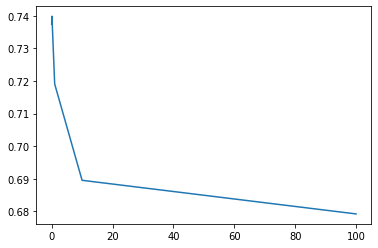

In [35]:
plt.plot(C, nSVM_F_score_list)
index_c = np.argmax(nSVM_F_score_list)
print('The best C = {}, with the best F1 score = {}.' .format(C[index_c], max(nSVM_F_score_list)))

In [36]:
linear_svm = LinearSVC(C = 0.01)
linear_svm.fit(x_Ntrain,y_Ntrain)
importance_svm = linear_svm.coef_
index_svm = np.argmax(importance_svm)
important_word = count_vectorizer.get_feature_names()
print('The most imprtant word is ' + important_word[index_svm])

The most imprtant word is laden


In [37]:
# Non-linear SVM prediction.
C = [0.01, 0.1, 1.0, 10.0, 100.0]
Fnonlear_list = []
for i in C:
    nonlinear_svm = SVC(kernel='rbf', C = i, probability = True, gamma='auto')
    nonlinear_svm.fit(x_Ntrain,y_Ntrain)
    nonlinear_predict_binary = nonlinear_svm.predict(x_Ndev)
    Fnonlear_score = f1_score(y_Ndev,nonlinear_predict_binary)
    Fnonlear_list.append(Fnonlear_score)
    
Fnonlear_list


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.0, 0.0, 0.0, 0.6335570469798658, 0.7419354838709676]

The best C = 100.0, with the best F1 score = 0.7419354838709676.


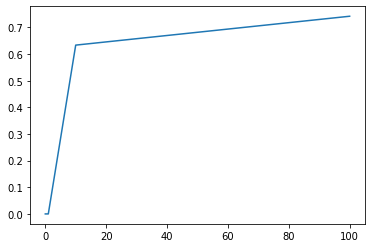

In [38]:
plt.plot(C, Fnonlear_list)
index_c = np.argmax(Fnonlear_list)
print('The best C = {}, with the best F1 score = {}.' .format(C[index_c], max(Fnonlear_list)))

# j) Incorporating the additional columns.

We used bag of word model since N-gram model reaches less accurate result and significantly slower, thus bag of word model will be more effient and give a fairly good result.  

For e) naive Bayes model, F1 score = 0.7469879518072289 

For f) bag of word model Logistic regression prediction, F score = 0.7414163090128756, and the most important words for deciding whether a tweet is about a real disaster or not is: hiroshima;


For g) bag of word model Linear SVM prediction, The best C = 0.01, with the best F1 score = 0.7402298850574713, which is slightly less than Logistic regression's F score, the important word is hiroshima which is same to the most important words for Logistic regression;


For h) bag of word model Non-linear SVM prediction: The best C = 100.0, with the best F1 score = 0.7519818799547.


Regarding all F score, the best performance classifier is Non-linear SVM prediction, all F scores are similar but slightly larger than previous reduced model, it probably because additional feature increase the prediction  to the real disaster.

In [43]:
new_train = train
new_dev = dev
cols = ['keyword', 'location', 'preprocessed_text']
new_train["new"] = new_train[cols].apply(lambda x: ' '.join(x.dropna()), axis=1)
new_dev["new"] = new_dev[cols].apply(lambda x: ' '.join(x.dropna()), axis=1)
new_train['new'].apply(lambda x: lemmatize_sentence(x))
new_dev['new'].apply(lambda x: lemmatize_sentence(x))
new_train['new'].apply(lambda x: no_punctuations(x))
new_dev['new'].apply(lambda x: no_punctuations(x))
stop = stopwords.words('english')
new_train['new'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
new_dev['new'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
new_dev.head()

,id,keyword,location,text,target,Lemmatize,no_punctuations,preprocessed_text,new
2644,3796,destruction,NaN,so you have a new weapon that can cause un-ima...,1,so you have a new weapon that can cause un-ima...,so you have a new weapon that can cause unimag...,new weapon cause unimaginable destruction,destruction new weapon cause unimaginable dest...
2227,3185,deluge,NaN,the f$&amp;@ing things i do for #gishwhes just...,0,the f $ & amp ; @ ing thing i do for # gishwhe...,the f amp ing thing i do for gishwhes jus...,f amp ing thing gishwhes get soak deluge go pa...,deluge f amp ing thing gishwhes get soak delug...
5448,7769,police,uk,dt @georgegalloway: rt @galloway4mayor: ûïthe...,1,dt @ georgegalloway : rt @ galloway4mayor : û...,dt georgegalloway rt galloway4mayor ûïthe...,dt georgegalloway rt galloway4mayor ûïthe col...,police uk dt georgegalloway rt galloway4mayor ...
132,191,aftershock,NaN,aftershock back to school kick off was great. ...,0,aftershock back to school kick off be great . ...,aftershock back to school kick off be great i...,aftershock back school kick great want thank e...,aftershock aftershock back school kick great w...
6845,9810,trauma,"montgomery county, md",in response to trauma children of addicts deve...,0,in response to trauma child of addict develop ...,in response to trauma child of addict develop ...,response trauma child addict develop defensive...,"trauma montgomery county, md response trauma c..."


In [44]:
#bag of word
count_vectorizer = CountVectorizer(binary=True,min_df=5)
train_vectors = count_vectorizer.fit_transform(new_train['new']).toarray()
dev_vectors = count_vectorizer.transform(new_dev['new']).toarray()
print(train_vectors.shape)
print(dev_vectors.shape)
print( 'total number of features in these vector is {}'.format(dev_vectors.shape[1]))
x_train = train_vectors
y_train = train['target']
x_dev = dev_vectors
y_dev = dev['target']

(5329, 2174)
(2284, 2174)
total number of features in these vector is 2174


In [45]:
#naive Bayes classifier.
nb_pridict = Naive_Bayes(x_train, y_train, x_dev)
F_score = f1_score(y_dev,nb_pridict)
print('F1 score = ' + str(F_score))

F1 score = 0.7469879518072289


In [41]:
# Logistic regression prediction for combined data.
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
log_predict_binary = logreg.predict(x_dev)
F_score = f1_score(y_dev,log_predict_binary)
print(F_score)
importance = logreg.coef_
index_word = np.argmax(importance)
important_word = count_vectorizer.get_feature_names()
important_word[index_word]

0.7414163090128756


/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'hiroshima'

/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.7402298850574713, 0.7359913793103448, 0.7086126869520373, 0.6828282828282828, 0.6490528414755733]
The best C = 0.01, with the best F1 score = 0.7402298850574713.
The most imprtant word is hiroshima


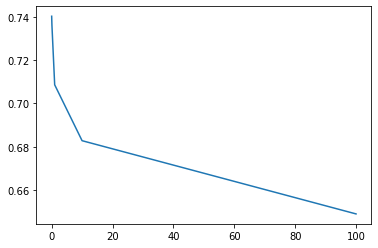

In [42]:
# g) Linear SVM prediction   
C = [0.01, 0.1, 1.0, 10.0, 100.0]
F_score_list = []
for i in C:
    linear_svm = LinearSVC(C = i)
    linear_svm.fit(x_train,y_train)
    linear_predict_binary = linear_svm.predict(x_dev)
    F_score = f1_score(y_dev,linear_predict_binary)
    F_score_list.append(F_score)
print(F_score_list)
plt.plot(C, F_score_list)
index_c = np.argmax(F_score_list)
print('The best C = {}, with the best F1 score = {}.' .format(C[index_c], max(F_score_list)))
linear_svm = LinearSVC(C = 0.01)
linear_svm.fit(x_train,y_train)
importance_svm = linear_svm.coef_
index_svm = np.argmax(importance_svm)
important_word = count_vectorizer.get_feature_names()
print('The most imprtant word is ' + important_word[index_svm])

/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sylvia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.0, 0.0, 0.0, 0.6791277258566978, 0.7519818799547]
The best C = 100.0, with the best F1 score = 0.7519818799547.


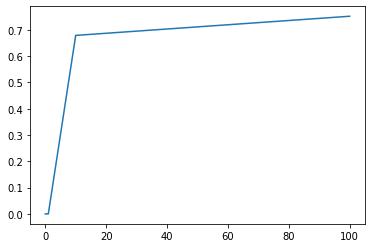

In [43]:
# h) Non-linear SVM prediction. 
C = [0.01, 0.1, 1.0, 10.0, 100.0]
Fnonlear_list = []
for i in C:
    nonlinear_svm = SVC(kernel='rbf', C = i, probability = True, gamma='auto')
    nonlinear_svm.fit(x_train,y_train)
    nonlinear_predict_binary = nonlinear_svm.predict(x_dev)
    Fnonlear_score = f1_score(y_dev,nonlinear_predict_binary)
    Fnonlear_list.append(Fnonlear_score)  
print(Fnonlear_list)
plt.plot(C, Fnonlear_list)
index_c = np.argmax(Fnonlear_list)
print('The best C = {}, with the best F1 score = {}.' .format(C[index_c], max(Fnonlear_list)))

# (k) Finalizing your model.
Out of all of the joint approaches we have considered so far, we believe 'Bag of Word' method with nonliear SVM method and using all features (keyword, text and location) will give use the most accurate result. According to the previouse test, this method have the highest F score.     

After submitting to Kaggle, we get F score = 0.78455, which is close and slightly higher than our expectation, it shows that non linear SVM makes most correlated feature condtribue more to the prediction, thus it handle the text analyzing well.

In [21]:
#preprocess of data
df_test = pd.read_csv('test.csv', dtype={'id': np.int16})
df_test = df_test.applymap(lambda s:s.lower() if type(s) == str else s)
cols = ['keyword', 'location', 'text']
df_test["new"] = df_test[cols].apply(lambda x: ' '.join(x.dropna()), axis=1)
df_test['Lemmatize'] = df_test['new'].apply(lambda x: lemmatize_sentence(x))
df_test["no_punctuations"] = df_test['Lemmatize'].apply(lambda x: no_punctuations(x))
stop = stopwords.words('english')
df_test['preprocessed_text'] = df_test['no_punctuations'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df_test.head()


,id,keyword,location,text,new,Lemmatize,no_punctuations,preprocessed_text
0,0,NaN,NaN,just happened a terrible car crash,just happened a terrible car crash,just happen a terrible car crash,just happen a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s...","heard about #earthquake is different cities, s...","heard about # earthquake be different city , s...",heard about earthquake be different city sta...,heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...","there be a forest fire at spot pond , geese be...",there be a forest fire at spot pond geese be ...,forest fire spot pond geese flee across street...
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,apocalypse lighting. #spokane #wildfires,apocalypse light . # spokane # wildfire,apocalypse light spokane wildfire,apocalypse light spokane wildfire
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kill 28 in china and taiwan,typhoon soudelor kill 28 in china and taiwan,typhoon soudelor kill 28 china taiwan


In [27]:
#bag of word
count_vectorizer = CountVectorizer(binary=True,min_df=5)
train_vectors = count_vectorizer.fit_transform(train['preprocessed_text']).toarray()
test_vectors = count_vectorizer.transform(df_test['preprocessed_text']).toarray()
print(test_vectors.shape)
print( 'total number of features in these vector is {}'.format(test_vectors.shape[1]))
x_train = train_vectors
y_train = train['target']
x_test = test_vectors


(3263, 1834)
total number of features in these vector is 1834


In [28]:
#non linear SVM
nonlinear_svm = SVC(kernel='rbf', C = 100, probability = True, gamma='auto')
nonlinear_svm.fit(x_train,y_train)
nonlinear_predict_binary = nonlinear_svm.predict(x_test)

In [29]:
nonlinear_predict_binary = [ int(x) for x in nonlinear_predict_binary ]
#submission
submission = pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = nonlinear_predict_binary
submission.to_csv('submission_nlSVM.csv', index=False)

# l) Reflecting on interpretability. 
 We will stick on the nonlinear model that we choose above. Firstly, we will not use Naive Bayes model since the model it rely on the assumption of conditional independence which is why is not reflecting the most accurate probability, it works good as an classifier but not work as an interpetable model, and we would rather use the SVM model(both linear SVM and Non linear SVM might work) since SVM model are good to show the relationship between features and results. SVM are more robust compare to the classic methods such as linear regression, so that only features that weight more will make significant impact to the result. Given the non lienar SVM reaches most accurate result and resons of using SVM, we will stick to that method. 